# Imports

In [1]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey
from jax import lax

from jax.config import config
config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

import equinox as eqx

from functools import partial

In [2]:
from jax_md import space

In [3]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import CellState, SpaceFunc
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield
from chem_twotypes.divrates import S_set_divrate

from chem_twotypes.initial_states import init_state_grow

In [4]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.9'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [5]:
import matplotlib.pyplot as plt

from tqdm import tqdm

# Set Parameters

In [6]:
ParamsDict = dict

In [154]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.array([1.,1.])
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
sec_max = sec_max.at[0].set(20.)
sec_max = sec_max.at[1].set(2.)


sec_gamma = .5* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 3.*np.ones((n_chem,n_chem), dtype=np.float32) 


# DIVISION

div_gamma = 2.*np.ones(n_chem, dtype=np.float32)
div_k = 3.*np.ones(n_chem, dtype=np.float32)
#div_k = div_k.at[0].set(5.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 3. #orange
eps_OneOne = 3. #blue
eps_OneTwo = 1. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 100


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 100
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

assert ncells_init > n_ones_init

In [155]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [156]:
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    
    'div_gamma' : True,
    'div_k' : True,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : False,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [157]:
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}



p, hp = eqx.partition(params, train_params)

# Simulation

In [158]:
key = PRNGKey(0)

## Generate initial state

In [16]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)


## Generate init-apply functions

In [17]:
# functions in this list will be executed in the given order
# at each simulation step
fstep = [
    S_cell_division,
    partial(S_grow_cells, grate=.05),
    S_mechmin_twotypes,
    S_ss_chemfield,
    S_set_divrate
]

sim_init, sim_step = simulation(fstep, params, fspace)

# Optimization

In [18]:
import equinox as eqx

from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from functools import partial

## Metrics

In [19]:
def diff_avg_divrates(state):
    
    #get index vectors for each type
    ctype_one = np.where(state.celltype==1,1,0)
    ctype_two = np.where(state.celltype==2,1,0)
    
    #get average divrate of each type 
    avdiv_one=np.sum(state.divrate*ctype_one)/np.sum(ctype_one)
    avdiv_two=np.sum(state.divrate*ctype_two)/np.sum(ctype_two)

    diff = avdiv_one-avdiv_two
    
    return diff


def diff_n_ctypes(state, relative=False):
    
    ctype_one = np.where(state.celltype==1,1,0).sum()
    ctype_two = np.where(state.celltype==2,1,0).sum()
    
    diff = ctype_one-ctype_two
    
    if relative:
        diff = diff/np.where(state.celltype!=0,1,0).sum()
    
    return diff

## Losses

In [20]:
from jax import lax

### Simple Loss (no logp)

In [21]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def simple_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_n_ctypes,#diff_avg_divrates, 
            target_metric=0.,
           ):
    '''
    Only calculates the deterministic part of the square loss, does not manage stochastic nodes.
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2))

    return loss

### REINFORCE Loss

In [34]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def reinforce_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_n_ctypes,#diff_avg_divrates, 
            target_metric=0.,
            GAMMA=.9,
           ):
    '''
    REINFORCE loss with discounting. 
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, logp = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2)) 
    
    steps = len(logp)
    discounted_losses = np.array([(GAMMA**(steps-i))*loss for i in np.arange(steps)])
    
    loss = np.sum(logp*lax.stop_gradient(discounted_losses))

    return loss

### Combined Loss (simple + logp)

In [23]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def combined_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_n_ctypes,#diff_avg_divrates, 
            target_metric=0.,
            GAMMA=.9,
           ):
    '''
    REINFORCE loss with discounting and loss gradient contribution. 
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, logp = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2))
    
    steps = len(logp)
    discounted_losses = np.array([(GAMMA**(steps-i))*loss for i in np.arange(steps)])
    
    return loss + np.sum(logp*lax.stop_gradient(discounted_losses))

### Ensembling

In [24]:
#@eqx.filter_jit #NO JIT IS FASTER IN THIS CASE
def avg_loss(params, hyper_params, vloss_fn, sim_keys, **kwargs):
    
    lss = vloss_fn(params, hyper_params, sim_key=sim_keys, **kwargs)
    
    return np.mean(lss)

#### Loss distribution

In [25]:
%%time

key, *subkeys = split(key, 101)
subkeys = np.array(subkeys)

p, hp = eqx.partition(params, train_params)

lss = simple_loss(p, hp, fstep, fspace, istate, subkeys)

CPU times: user 7 s, sys: 1.81 s, total: 8.81 s
Wall time: 6.44 s


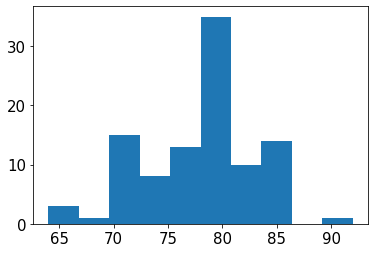

In [26]:
plt.hist(np.sqrt(lss).tolist());

In [27]:
np.mean(np.sqrt(lss))

DeviceArray(77.84, dtype=float32)

#### Mean loss grad

## Initialization

In [26]:
#def add_noise(leaf, ):
    
    

## Optimization loop

In [159]:
EPOCHS = 50
EPISODES_PER_UPDATE = 32

LEARNING_RATE = .1


p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)


ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
params_t = [p]
loss_t = [float(l)]

#--------------------------------------------






for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    
    # sgd step
    #updates, opt_state = optimizer.update(jax.tree_map(lambda x: -x, grads), opt_state, p)
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, reinforce_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    #estimate actual avg loss
    l = avg_loss(p, hp, simple_loss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
    #store
    loss_t.append(float(l))
    params_t.append(p)

/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)
100%|████████████████████████████████████████████████| 50/50 [02:57<00:00,  3.56s/it]


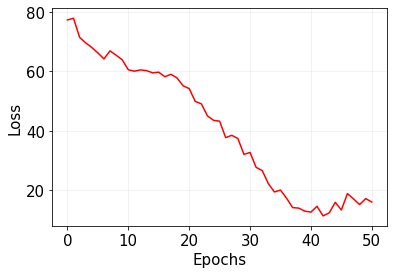

In [197]:

plt.plot(np.sqrt(np.array(loss_t)), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)

plt.xlabel('Epochs')
plt.ylabel('Loss');

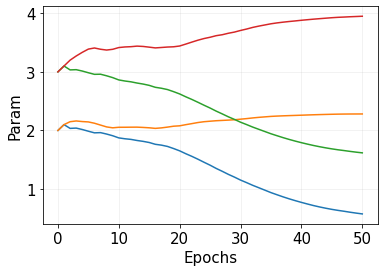

In [161]:
p_timecourse = np.array([np.array(jax.tree_flatten(pt)[0]).flatten().tolist() for pt in params_t]).T.tolist()

for pt in p_timecourse:
    plt.plot(pt)

plt.grid(alpha=.2)

plt.xlabel('Epochs')
plt.ylabel('Param');

In [162]:
key, *subkeys = split(key, 301)
subkeys = np.array(subkeys)

lss = simple_loss(p, hp, fstep, fspace, istate, subkeys)



/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)


13.04 9.611714


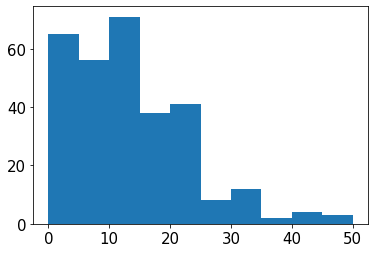

In [163]:
print(np.mean(np.sqrt(lss)), np.std(np.sqrt(lss)))

plt.hist(np.sqrt(lss).tolist());

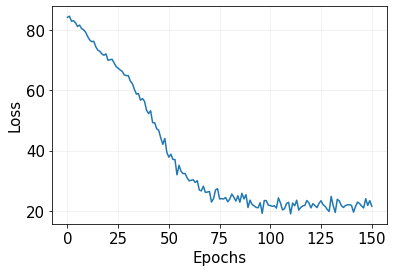

In [505]:
plt.plot(np.sqrt(np.array(loss_t)))
#plt.yscale('log')

plt.grid(alpha=.2)

plt.xlabel('Epochs')
plt.ylabel('Loss');

### Opt params 

#### Original Size

In [164]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, subkey)

In [165]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(1.4197352e-05, dtype=float32)

In [166]:
diff_n_ctypes(fstate)

DeviceArray(18, dtype=int32)

In [167]:
diff_n_ctypes(fstate, relative=True)

DeviceArray(0.16363636, dtype=float32)

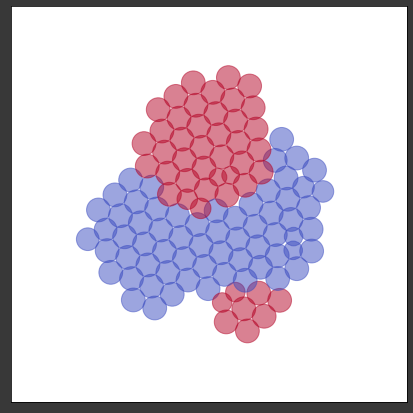

In [168]:
draw_circles_ctype(fstate);

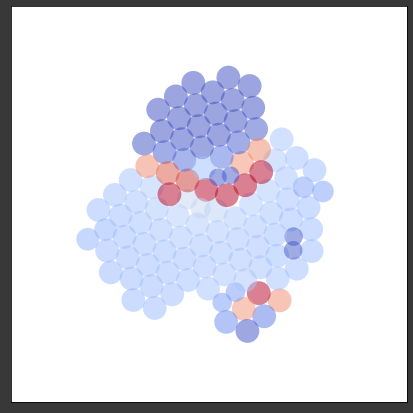

In [169]:
draw_circles_divrate(fstate);

#### Bigger system

In [170]:
# merge params dicts
all_params = eqx.combine(p, hp)

#run bigger simulation
all_params['ncells_add'] = 500

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [171]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(0.00312569, dtype=float32)

In [172]:
diff_n_ctypes(fstate, relative=True), diff_n_ctypes(fstate)

(DeviceArray(0.41176468, dtype=float32), DeviceArray(210, dtype=int32))

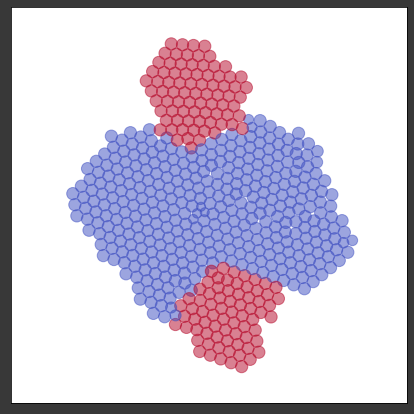

In [173]:
draw_circles_ctype(fstate);

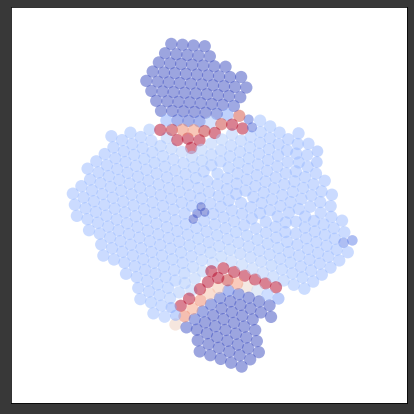

In [174]:
draw_circles_divrate(fstate);

### Initial params 

#### Original size

In [175]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [176]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(2.0852582e-05, dtype=float32)

In [177]:
diff_n_ctypes(fstate, relative=True), diff_n_ctypes(fstate)

(DeviceArray(-0.6909091, dtype=float32), DeviceArray(-76, dtype=int32))

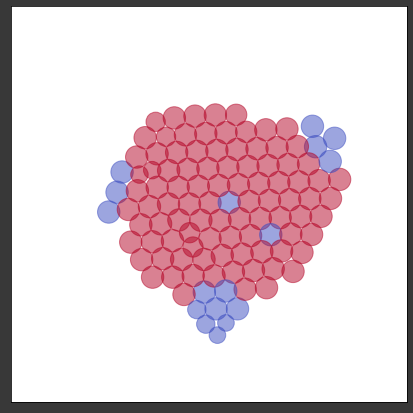

In [178]:
draw_circles_ctype(fstate);

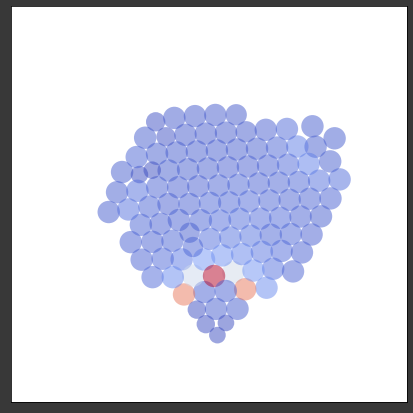

In [179]:
draw_circles_divrate(fstate);

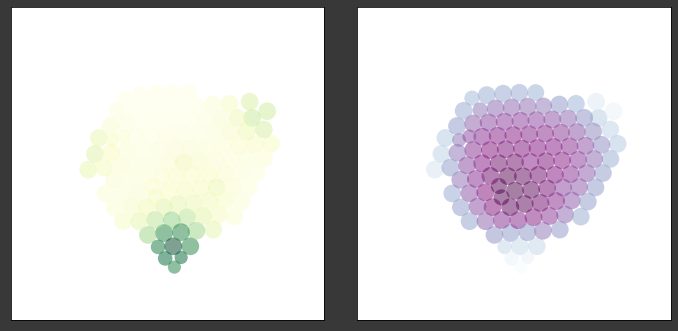

In [180]:
ax = plt.subplot(121, box_aspect=1.)
draw_circles_chem(fstate, 0, ax);

ax = plt.subplot(122, box_aspect=1.)
draw_circles_chem(fstate, 1, ax);

plt.gcf().set_size_inches(10, 10)

[0.6272413  0.26667774]


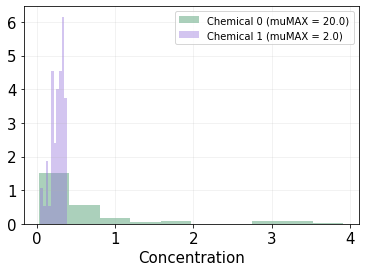

In [181]:
plt.hist(fstate.chemical[:,0].tolist(), density=True, alpha=.4, color='seagreen', label='Chemical 0 (muMAX = {})'.format(hp['sec_max'][0]));
plt.hist(fstate.chemical[:,1].tolist(), density=True, alpha=.4, color='mediumpurple', label='Chemical 1 (muMAX = {})'.format(hp['sec_max'][1]));

plt.grid(alpha=.2)

plt.xlabel('Concentration')

plt.legend(fontsize=10);

print(fstate.chemical.mean(0))

#### Bigger system

In [182]:
pp = params.copy()

#run bigger simulation
pp['ncells_add'] = 500

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [183]:
# Calculate metric of final structure
diff_avg_divrates(fstate)**2

DeviceArray(3.5245891e-06, dtype=float32)

In [184]:
diff_n_ctypes(fstate, relative=True), diff_n_ctypes(fstate)

(DeviceArray(-0.87450975, dtype=float32), DeviceArray(-446, dtype=int32))

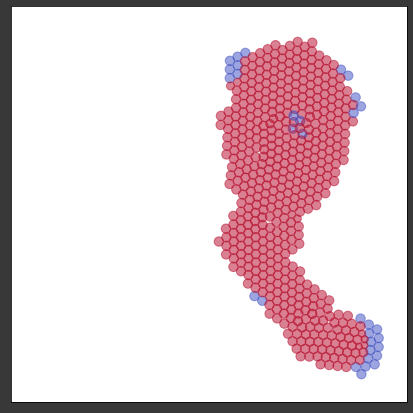

In [185]:
draw_circles_ctype(fstate);

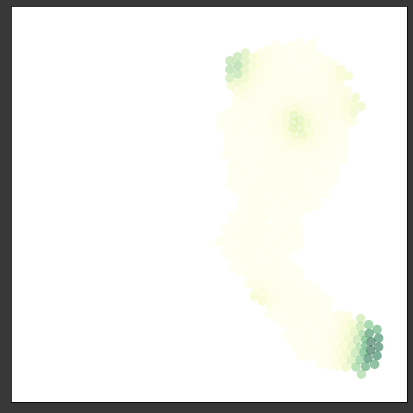

In [186]:
draw_circles_chem(fstate);

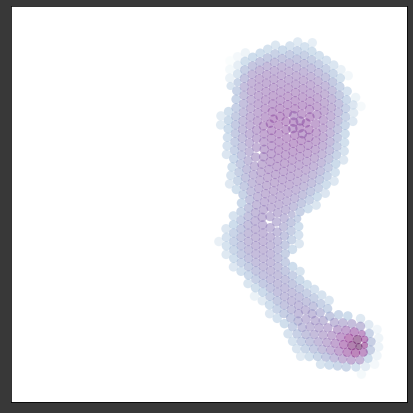

In [187]:
draw_circles_chem(fstate, 1);

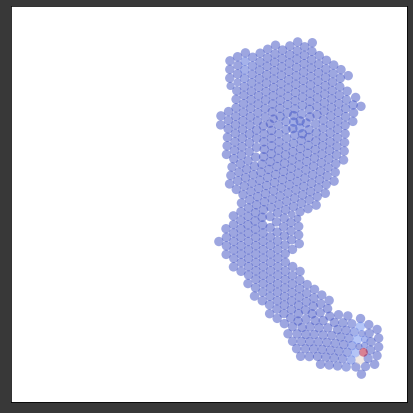

In [188]:
draw_circles_divrate(fstate);

[0.28429943 0.29853976]


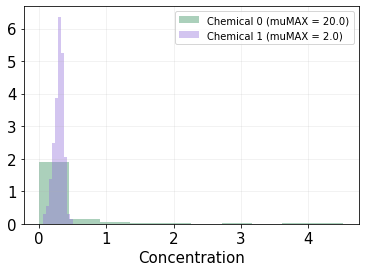

In [189]:
plt.hist(fstate.chemical[:,0].tolist(), density=True, alpha=.4, color='seagreen', label='Chemical 0 (muMAX = {})'.format(hp['sec_max'][0]));
plt.hist(fstate.chemical[:,1].tolist(), density=True, alpha=.4, color='mediumpurple', label='Chemical 1 (muMAX = {})'.format(hp['sec_max'][1]));

plt.grid(alpha=.2)

plt.xlabel('Concentration')

plt.legend(fontsize=10);

print(fstate.chemical.mean(0))

### Curve comparison

In [190]:
from jax_morph.utils import logistic

#### Division

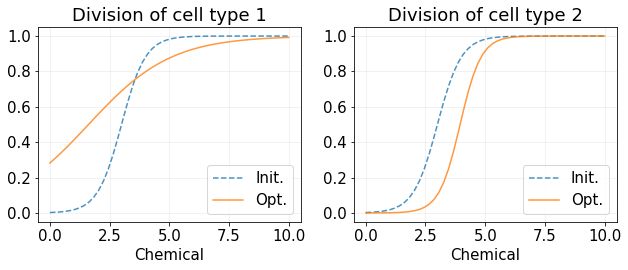

In [191]:
xx = np.linspace(0,10,50)

for ct in range(2):
    
    ax = plt.subplot(1,2,ct+1)
    
    ax.plot(xx, logistic(xx, params['div_gamma'][ct], params['div_k'][ct]), '--', alpha=.8, label='Init.')
    
    ax.plot(xx, logistic(xx, p['div_gamma'][ct], p['div_k'][ct]), alpha=.8, label='Opt.')
    
    ax.set_ylim(-.05, 1.05)
    
    ax.grid(alpha=.2)
    
    ax.set_xlabel('Chemical')
    ax.set_title(f'Division of cell type {ct+1}')

    ax.legend(loc='lower right');
    
    
plt.gcf().set_size_inches(9, 4)
plt.gcf().tight_layout()

#### Secretion

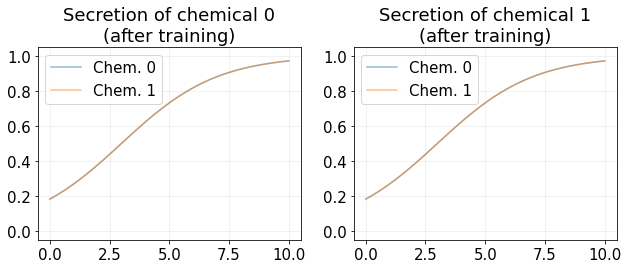

In [192]:
for c in range(2):

    ax = plt.subplot(1,2,c+1)

    ax.plot(xx, logistic(xx, hp['sec_gamma'][c,0], hp['sec_k'][c,0]), alpha=.5, label='Chem. 0')
    ax.plot(xx, logistic(xx, hp['sec_gamma'][c,1], hp['sec_k'][c,1]), alpha=.5, label='Chem. 1')

    ax.set_title(f'Secretion of chemical {c}\n(after training)')
    
    ax.grid(alpha=.2)
    
    ax.set_ylim(-.05,1.05)
    ax.legend()


plt.gcf().set_size_inches(9, 4)
plt.gcf().tight_layout()

In [193]:
def sec_one(c,smax,sg,sk):    
    return smax*logistic(c[0],sg[0],sk[0])*logistic(c[1],sg[1],sk[1])

def sec_chem_grid(c_grid, p, c=0):
    
    smax = p['sec_max'][c]
    sk = p['sec_k'][c, :]
    sg = p['sec_gamma'][c, :]
    
    s = vmap(sec_one, in_axes=(0,None,None,None))(c_grid.reshape(-1,2),smax,sg,sk).reshape(c_grid[:,:,0].shape)
    
    return s

In [194]:
def draw_sec_response(params, c=0, c_max=np.asarray([50,50]), pts_max=150):
    
    def str_and_trunc(values):
        return [f'{v:.1f}' for v in values]
    

    #max number of sampling points is 100
    #rescale the number of pts on the other axis to keep same resolution
    n_pts = [pts_max,pts_max]
    i = np.argmin(c_max)
    n_pts[i] = int(np.ceil(c_max.min()/c_max.max()*pts_max))

    c0 = np.linspace(0,c_max[0],n_pts[0])
    c1 = np.linspace(0,c_max[1],n_pts[1])

    c_grid = np.stack(np.meshgrid(c0,c1[::-1]),2)

    s = sec_chem_grid(c_grid, params, c=c)
    
    
    
    plt.imshow(s)
    plt.colorbar(label=f'Sec. Chemical {c}')
    
    plt.xlabel('Chem. 0')
    plt.ylabel('Chem. 1')

    plt.xticks(ticks=np.arange(n_pts[0])[::10], labels=str_and_trunc(c0[::10]), rotation=45)
    plt.yticks(ticks=np.arange(n_pts[1])[::10], labels=str_and_trunc(c1[::-10]), rotation=45);

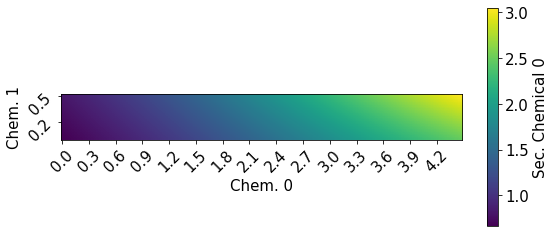

In [195]:
draw_sec_response(params, c=0, c_max=fstate.chemical.max(0))

plt.gcf().set_size_inches(9, 4)

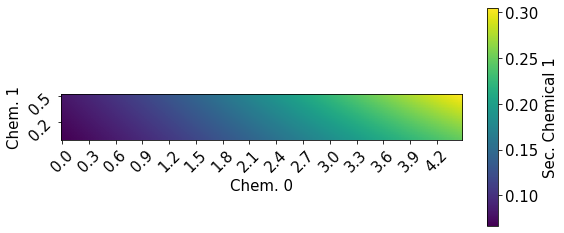

In [196]:
draw_sec_response(params, c=1, c_max=fstate.chemical.max(0))

plt.gcf().set_size_inches(9, 4)